## Final assignment part 2/2 - Analysis and Visualizing results


Continuing with proper subset of data. 

In this part we calculate forest area statistics for each ecoregion, based on the boolean forest cover raster. Forest cells (1) and non-forest cells (0) have their own distinct value, and we will count those. As result we get both absolute amount of forest covered area, and forest proportion of total land area (%), that are visualized in graphs and choroplete maps.  




In [60]:
import geopandas as gpd
import pandas as pd
import fiona
from pyproj import CRS
import os
import numpy as np

import matplotlib.pyplot as plt
import mapclassify

import rasterio
from rasterio.mask import mask
import json


In [2]:
# read in and open forest area raster
forest = rasterio.open('data/forest/eea_r_3035_100_m_forest-area-2015_p_2015_v1_r1.tif')


In [3]:
# read in subset of European forest ecoregions
eco = gpd.read_file('data/ecoregions_subset/forest_ecoregs.shp')


## Iterating over ecoregions - analysis phase

In each iteration, following operations are done:
- Masking raster with ecoregion
- Counting forest pixels and non-forest pixels and their ratio
- Saving results in ecoregion dataframe into three new columns


In [4]:
# function to get shapes of ecoregions for masking
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [5]:
# empty columns for results
eco['forest_area_1000km2']= None       # absolute forest area (thousands of square kilometers)
eco['total_landarea_1000km2']= None    # absolute non-forest area (thousands of square kilometers)
eco['forest_prop%']= None              # Percentage of ecoregion area covered by forest

In [6]:
print("------------------------------")
for i in range(0,len(eco)):
    
    # row to one-row geodataframe
    geo = eco.iloc[[i]]
    
    ### 
    print(i+1, "/", len(eco), " - ", geo.iloc[0]['ECO_NAME'])  # (progess sign)
    ###
    
    # get ecoregion shape for masking
    shapes = getFeatures(geo)
    
    # Clip subset of forest raster with ecoregion shape
    out_image, out_transform = mask(dataset=forest, shapes=shapes, crop=True)
    out_meta = forest.meta.copy()    
    
    # update shape
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    
    # extract raster value array
    band1 = out_image[0] 
    
    ###
    print("------------------------------") # (progress sign)
    ###
    
    # calculate forest statistics of raster  
    # (spatial resolution is 100m, so one pixel is one hectare)
    
    eco.at[i,'forest_area_1000km2'] = len(band1[band1==1])/100 /1000         # ha -> thousands km2
    eco.at[i,'total_landarea_1000km2'] = len(band1[band1==0])/100 /1000      # ha -> thousands km2
    eco.at[i,'forest_prop%'] = len(band1[band1==1])/ (len(band1[band1==0]) + len(band1[band1==1])) *100  # %
    


------------------------------
1 / 36  -  Aegean And Western Turkey Sclerophyllous And Mixed Forests
------------------------------
2 / 36  -  Alps Conifer And Mixed Forests
------------------------------
3 / 36  -  Appenine Deciduous Montane Forests
------------------------------
4 / 36  -  Atlantic Mixed Forests
------------------------------
5 / 36  -  Balkan Mixed Forests
------------------------------
6 / 36  -  Baltic Mixed Forests
------------------------------
7 / 36  -  Caledon Conifer Forests
------------------------------
8 / 36  -  Cantabrian Mixed Forests
------------------------------
9 / 36  -  Carpathian Montane Forests
------------------------------
10 / 36  -  Celtic Broadleaf Forests
------------------------------
11 / 36  -  Central European Mixed Forests
------------------------------
12 / 36  -  Corsican Montane Broadleaf And Mixed Forests
------------------------------
13 / 36  -  Crete Mediterranean Forests
------------------------------
14 / 36  -  Dinaric Moun

## Visualizing results - Distribution graphs

In [21]:
# Sort data descending by forest percentage. Used in graph visualization.
prop_desc = eco.sort_values(by=['forest_prop%'], ascending = False)


#### Which ecoregions have the highest and lowest percentages of forest cover?

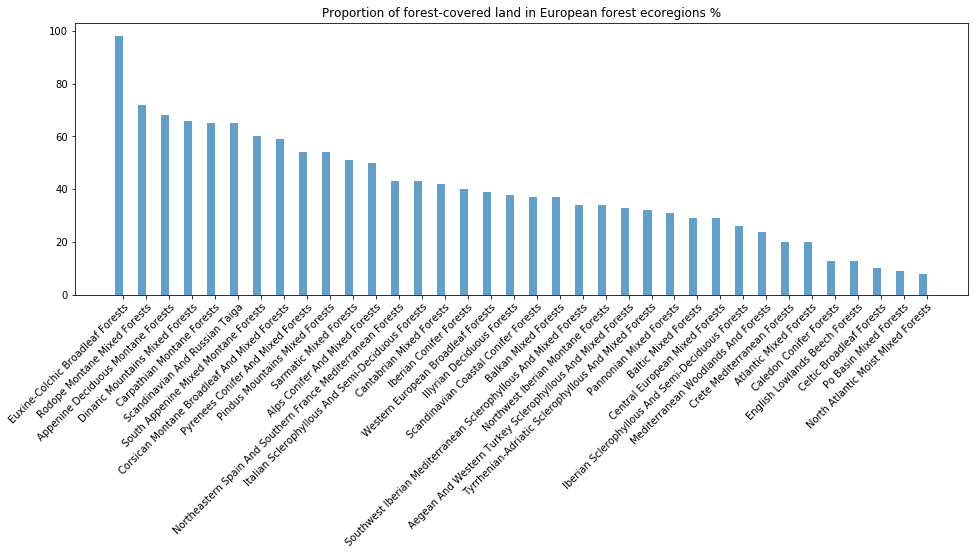

In [55]:
# Comparing forest percentage between ecoregions

labels = prop_desc['ECO_NAME'] # label by ecoregion name
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(16,5))

rects1 = ax.bar(x - 0.35/2, prop_desc['forest_prop%'], 0.35, alpha = 0.7)

ax.set_title('Proportion of forest-covered land in European forest ecoregions %')

# ecoregion labels 
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor");

#### Which ecoregions have the highest and the lowest absolute amounts of forest area?

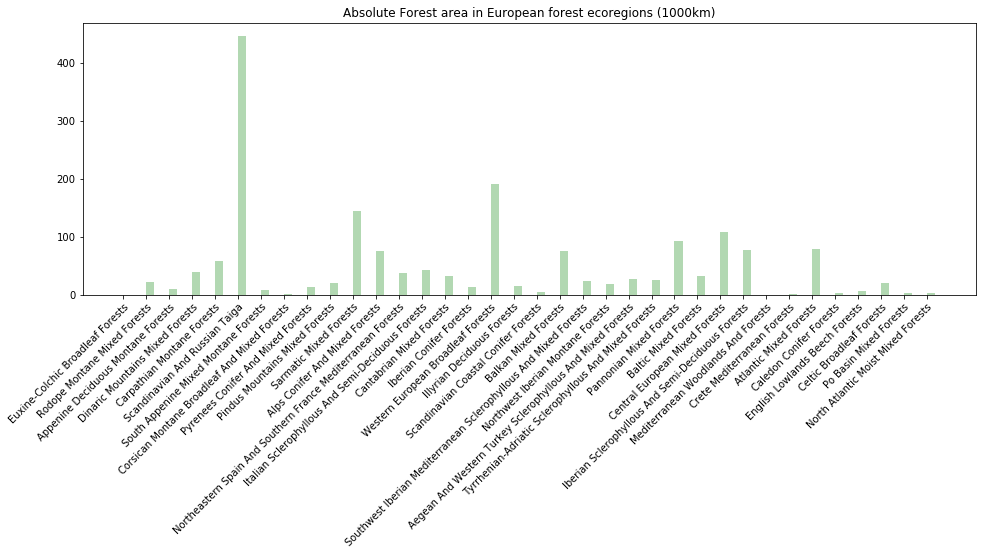

In [75]:
# Comparing total forest area between ecoregions

# Bars in same order as in previous graph - from highest percentage to lowest

labels = prop_desc['ECO_NAME']
x = np.arange(len(labels))


fig, ax = plt.subplots(figsize=(16,5))

#rects1 = ax.bar(x - 0.35/2, prop_desc['forest_prop%'], 0.35)
rects2 = ax.bar(x + 0.35/2, prop_desc['forest_area_1000km2'], 0.35, color = 'green', alpha = 0.3)
ax.set_title('Absolute Forest area in European forest ecoregions (1000km)')
#ax.set_ylim(0,100)

# ecoregion labels 
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor");


## Visualizing results - Maps

In [56]:
# Preparing data

# Floats bug in map classification for some reason, so they have to be converted to integers
# Also rounding normally causes error, so rounding by adding 0.5

eco['forest_prop%'] = (eco['forest_prop%'] + 0.5).astype(int) # round and convert to integer
eco['forest_area_1000km2'] = (eco['forest_area_1000km2'] + 0.5).astype(int) # round and convert to integer


#### Percentage of forest-covered area (%)

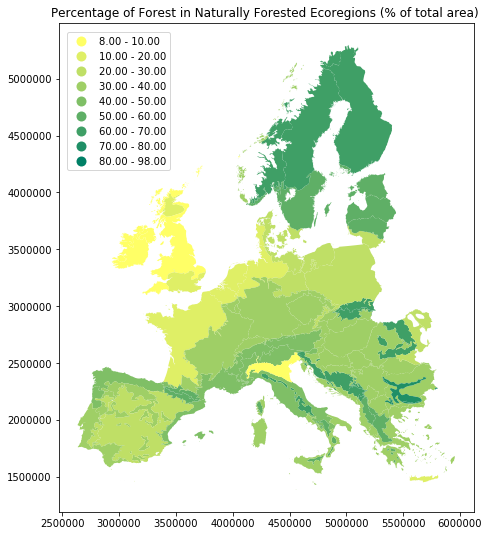

In [67]:

%matplotlib inline

fig, ax = plt.subplots(figsize=(12,9))
eco.plot(ax=ax, column='forest_prop%', 
         #cmap= 'RdYlGn',
         cmap= 'summer_r', 
         #scheme = 'quantiles',
         #k=4,
         scheme='User_Defined', 
         classification_kwds=dict(bins=[10,20,30,40,50,60,70,80]), 
         legend=True) 
ax.get_legend().set_bbox_to_anchor((.28, .99))
plt.title('Percentage of Forest in Naturally Forested Ecoregions (% of total area)')

outfp = "results/forestmap_percentage.png"
plt.savefig(outfp, dpi=120);

#### Absolute amount of forest-covered area (thousands of km2)

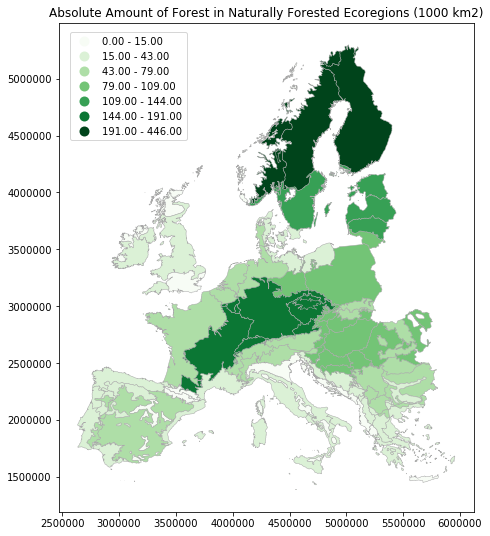

In [68]:
# check ecoregion data
%matplotlib inline

fig, ax = plt.subplots(figsize=(12,9))
eco.plot(ax=ax, column='forest_area_1000km2', 
         cmap= 'Greens', 
         scheme='naturalbreaks',
         edgecolor= 'darkgrey',
         linewidth = 0.5,
         k= 7,
         legend=True) 

ax.get_legend().set_bbox_to_anchor((.32, .99))
plt.title('Absolute Amount of Forest in Naturally Forested Ecoregions (1000 km2)')

outfp = "results/forestmap_absolute.png"
plt.savefig(outfp, dpi=120);